# Multiple Rectangles or Triangles

## Import Packages

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
%matplotlib inline

## Data Generation

In [58]:
num_imgs = 80000

img_size = 20
min_rect_size = 4
max_rect_size = 8
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size = 2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x + width, y:y + height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size = 2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
            
imgs.shape, bboxes.shape

((80000, 20, 20), (80000, 3, 4))

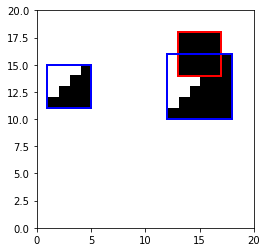

In [59]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r' if shape[0] == 0 else 'b', fc = 'none'))

## Preprocessing

In [60]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((80000, 400), -8.32698354713557e-17, 1.0000000000000013)

In [61]:
y = np.concatenate([bboxes / img_size, shapes], axis = -1).reshape(num_imgs, -1)
y.shape

(80000, 15)

## Train Test Split

In [62]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Model

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.5), 
        Dense(y.shape[-1])
    ])
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               102656    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                3855      
Total params: 106,511
Trainable params: 106,511
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [64]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating Function

In [65]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [66]:
from itertools import permutations
num_epochs = 50
fact = math.factorial(num_objects)

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epochs = np.zeros((len(flipped_train_y), num_epochs))
dists_epochs = np.zeros((len(flipped_train_y), num_epochs))
mses_epochs = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch ', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1, 
              callbacks = [ModelCheckpoint('Multiple_Rectangles_or_Triangles_model.h5', 
                                           monitor = 'val_loss',
                                           save_best_only = True)])
    pred_y = model.predict(train_X)
    
    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred_bboxes = pred_bboxes.reshape(num_objects, -1)
        exp_bboxes = exp_bboxes.reshape(num_objects, -1)
        
        p_exp_bboxes = list(permutations(exp_bboxes))
        ious = np.zeros((fact, num_objects))
        dists = np.zeros((fact, num_objects))
        mses = np.zeros((fact, num_objects))
        p_ious = np.zeros(fact)
        p_mses = np.zeros(fact)
        p_dists = np.zeros(fact)
        
        for j, exp_bboxes in enumerate(p_exp_bboxes):
            exp_bboxes = list(exp_bboxes) 
            for k in range(num_objects):
                ious[j, k] = IOU(exp_bboxes[k], pred_bboxes[k])
                dists[j, k] = distance(exp_bboxes[k], pred_bboxes[k])
                mses[j, k] = np.mean(np.square(exp_bboxes[k] - pred_bboxes[k]))
            p_ious[j] = sum(ious[j, :])
            p_dists[j] = sum(dists[j, :])
            p_mses[j] = sum(mses[j, :])
            
        keymax = p_ious.argmax()
        ious_epochs[i, epoch] += p_ious[keymax] / num_objects
        dists_epochs[i, epoch] += p_dists[keymax] / num_objects
        mses_epochs[i, epoch] += p_mses[keymax] / num_objects
        
        flipped_train_y[i] = np.array(p_exp_bboxes[keymax]).flatten()
        if keymax != 0:
            flipped[i, epoch] = 1.
    
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epochs[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epochs[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epochs[:, epoch])))

Epoch  0
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0905 - val_loss: 0.0598
Flipped 79.46875 % of all elements
Mean IOU: 0.14729136563912337
Mean dist: 0.23595941983537283
Mean mse: 0.058931273661303525
Epoch  1
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0604 - val_loss: 0.0578
Flipped 56.765625 % of all elements
Mean IOU: 0.18100172305207218
Mean dist: 0.21750673897735145
Mean mse: 0.05467983897467881
Epoch  2
2000/2000 [==============================] - 2s 919us/step - loss: 0.0573 - val_loss: 0.0587
Flipped 46.5296875 % of all elements
Mean IOU: 0.23047849068268494
Mean dist: 0.19350158660022265
Mean mse: 0.05094580896892114
Epoch  3
2000/2000 [==============================] - 2s 912us/step - loss: 0.0537 - val_loss: 0.0603
Flipped 33.1515625 % of all elements
Mean IOU: 0.2728092598543508
Mean dist: 0.1706310920320937
Mean mse: 0.046537761192300776
Epoch  4
2000/2000 [==============================] - 2s 942us/step - loss: 0.0499 - va

2000/2000 [==============================] - 2s 891us/step - loss: 0.0382 - val_loss: 0.0662
Flipped 12.7875 % of all elements
Mean IOU: 0.35051968140881473
Mean dist: 0.13570221421415907
Mean mse: 0.029737489431023577
Epoch  37
2000/2000 [==============================] - 2s 893us/step - loss: 0.0380 - val_loss: 0.0651
Flipped 12.240625 % of all elements
Mean IOU: 0.3497489946120714
Mean dist: 0.13569294102134527
Mean mse: 0.029853140210960884
Epoch  38
2000/2000 [==============================] - 2s 897us/step - loss: 0.0380 - val_loss: 0.0665
Flipped 12.2625 % of all elements
Mean IOU: 0.3517207988951844
Mean dist: 0.13495622134558274
Mean mse: 0.029500872475833193
Epoch  39
2000/2000 [==============================] - 2s 956us/step - loss: 0.0381 - val_loss: 0.0667
Flipped 12.721874999999999 % of all elements
Mean IOU: 0.3520385246905413
Mean dist: 0.13561995233750782
Mean mse: 0.029623385966109417
Epoch  40
2000/2000 [==============================] - 2s 899us/step - loss: 0.0380 

In [37]:
num_epochs_flipping = 50
num_epochs_no_flipping = 0  # has no significant effect
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs_flipping):
    print 'Epoch', epoch
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1,
             callbacks = [ModelCheckpoint('Multiple_Rectangles_or_Triangles_model.h5', 
                                         monitor = 'val_loss', 
                                         save_best_only = True)])
    pred_y = model.predict(train_X)

    for i, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        # TODO: Try flipping array and see if results differ.
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[i, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[i, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[i, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 1000000#-1  # set iou of assigned bboxes to -1, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        flipped_train_y[i] = exp[new_order].flatten()
        
        ious_epoch[i, epoch] /= num_objects
        dists_epoch[i, epoch] /= num_objects
        mses_epoch[i, epoch] /= num_objects
        
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))

Epoch 0
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
4s - loss: 0.1505 - val_loss: 0.0559
Flipped 49.14 % of all elements
Mean IOU: 0.234211369772
Mean dist: 0.200727835348
Mean mse: 0.0169208188335

Epoch 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
4s - loss: 0.0558 - val_loss: 0.0499
Flipped 26.935 % of all elements
Mean IOU: 0.25961828597
Mean dist: 0.187458868204
Mean mse: 0.0144943950131

Epoch 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
4s - loss: 0.0501 - val_loss: 0.0479
Flipped 19.915 % of all elements
Mean IOU: 0.285665079779
Mean dist: 0.172386849031
Mean mse: 0.01265891626

Epoch 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
4s - loss: 0.0463 - val_loss: 0.0474
Flipped 14.9175 % of all elements
Mean IOU: 0.319045391304
Mean dist: 0.157677244358
Mean mse: 0.0111588802368

Epoch 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
4s - loss: 0.0434 - val_loss: 0.0484
Flipped 11.6025 % of all elements


## Flipping Track

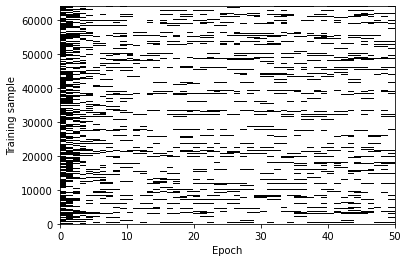

In [67]:
# Show flippings for a few training samples.
plt.pcolormesh(flipped[:, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('multiple-rectangles_or_triangles_flips.png', dpi = 100)
plt.show()

## Metrics Track

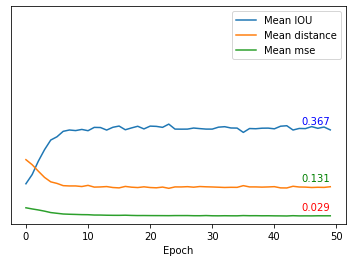

In [68]:
# Plot metrics on the training data.
mean_ious_epoch = np.mean(ious_epochs, axis = 0)
mean_dists_epoch = np.mean(dists_epochs, axis = 0)
mean_mses_epoch = np.mean(mses_epochs, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

plt.xlabel('Epoch')
# Hide y tick
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.legend()
plt.ylim(0, 0.8)
plt.savefig('training_metrics.png', dpi = 100)

## Denormalize Data

In [69]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((16000, 3, 4), (16000, 3, 1))

## Visualize Results

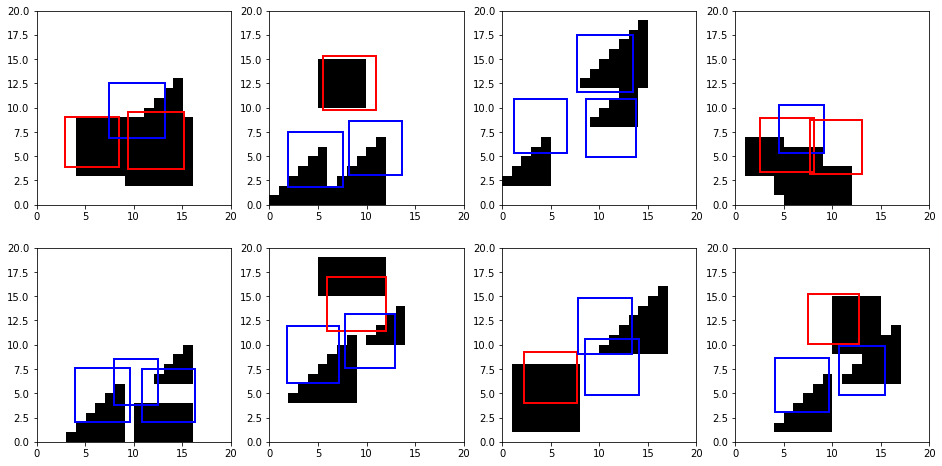

In [70]:
plt.figure(figsize = (16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r' if pred_shape[0] <= 0.5 else 'b', fc = 'none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

## Overall Assessment

In [71]:
from keras.models import load_model
from itertools import permutations
fact = math.factorial(num_objects)
model_test = load_model('Multiple_Rectangles_or_Triangles_model.h5')
pred_y = model_test.predict(test_X)
sum_iou = 0.
sum_dist = 0.
sum_mse = 0.
test_y = np.array(test_y)

for pred_bboxes, test_bboxes in zip(pred_y, test_y):
    
    pred_bboxes = pred_bboxes.reshape(num_objects, -1)
    test_bboxes = test_bboxes.reshape(num_objects, -1)
    
    p_test_bboxes = list(permutations(test_bboxes))
    p_ious = np.zeros(fact)
    p_dists = np.zeros(fact)
    p_mses = np.zeros(fact)
    ious = np.zeros((fact, num_objects))
    dists = np.zeros((fact, num_objects))
    mses = np.zeros((fact, num_objects))
    
    for j, test_bboxes in enumerate(p_test_bboxes):
        test_bboxes = list(test_bboxes) 
        for k in range(num_objects):
            ious[j, k] = IOU(test_bboxes[k], pred_bboxes[k])
            dists[j, k] = distance(test_bboxes[k], pred_bboxes[k])
            mses[j, k] = np.mean(np.square(test_bboxes[k] - pred_bboxes[k]))
        p_ious[j] = sum(ious[j, :])
        p_dists[j] = sum(dists[j, :])
        p_mses[j] = sum(mses[j, :])
            
    keymax = p_ious.argmax()
    sum_iou += p_ious[keymax] 
    sum_dist += p_dists[keymax] 
    sum_mse += p_mses[keymax] 

mean_iou = sum_iou / (num_objects * len(pred_y))
mean_dist = sum_dist / (num_objects * len(pred_y))
mean_mse = sum_mse / (num_objects * len(pred_y))
print('IoU:', mean_iou)
print('Distance:', mean_dist)
print('MSE:', mean_mse)

IoU: 0.34576230503956473
Distance: 0.13639853684211747
MSE: 0.030155285974093293
